In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
import os
from time import time
import numpy as np
import pandas as pd

from functools import reduce
from itertools import combinations
import operator
from scipy.optimize import minimize

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Custom imports
from resnet import ResNet, MultipleShallowNets
from train_functions import make_loaders
from compute_barcode import RegularizationL2, ComputeLoss

In [3]:
def factorize_net(net, save_gradients=True):
    n_models = net.N
    n_layers = net.n_layers
    networks, gradients = [[] for _ in range(n_models)], [{} for _ in range(n_models)]
    
    for index, (name, par) in enumerate(net.named_parameters()):
        
        params = par.cpu().detach().numpy().reshape(n_models, -1)
        
        if save_gradients:
            grad = par.grad.cpu().detach().numpy().reshape(n_models, -1)
        
        for index in range(n_models):
            networks[index].append(params[index].reshape(-1, 1))
            
            if save_gradients:
                gradients[index][str(index) + '_' + name] = grad[index].reshape(-1, 1)
            
    networks = [np.vstack(net) for net in networks]
        
    return np.hstack(networks), gradients

# Optimize straight path

In [ ]:
device = 'cuda:2'
dataset='SVHN'

models = ['Case1/Models/' + f for f in os.listdir('Case1/Models/')]
minimas = list(combinations(models, 2))

model_params = {'regularization': 1e-5}

L = ComputeLoss(model=ResNet, model_params=model_params, dataset=dataset,
                part='train', bs=150, device=device)

lr = {'lr': 2e-3, 'decay': 0.5, 'decay_each': 8, 'decay_from': 270}

log_parameters = {'log_dir': f'SHARP2_LOSS/', 'log_each': 20,
                  'plot_logs': True}

L.find_path_mini_batch(minimas[5:10], steps=201, points=19, lr=lr, log_parameters=log_parameters)

# Restart 

In [ ]:
device = 'cuda:2'
dataset='CIFAR10'

model_path = 'Case2/ResNet9_0.01_80_reg0'
models = [model_path + '/' + s for s in os.listdir(model_path)]
minimas = list(combinations(models, 2))

model_params = {'regularization': 1e-5}

L = ComputeLoss(model=ResNet, model_params=model_params, dataset=dataset,
                part='train', bs=150, device=device)

lr = {'lr': 2e-3, 'decay': 0.5, 'decay_each': 8, 'decay_from': 270}

log_parameters = {'log_dir': f'WidePath1/', 'log_each': 25,
                  'plot_logs': True}

res = {'stat_file': 'WidePath1/Stats.npy',
       'epochs': 225}

L.find_path_mini_batch(minimas[:10], steps=301, points=10, lr=lr, log_parameters=log_parameters,
                       restart=res)

points * len(pairs): 100
length of gradient cache: 10


New epoch started! 77


After Epoch 10
Grad Cache [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
New epoch started! 78


# Evaluate between

In [12]:
device = 'cuda:0'
dataset='CIFAR10'

model_params = {'regularization': 1e-5}

L = ComputeLoss(model=ResNet, model_params=model_params, dataset=dataset,
                part='train', bs=128, device=device)

out = L.evalutae_between_thetas('PATH_reg1e-5_20Points/Stats.npy', alpha=4, dataset_ratio=1/5, plot=False)
np.save('PATH_reg1e-5_20Points/Between.npy', out)

Ratio 0.2
(78, 57, 195210, 1)
Ratio 0.4
(78, 57, 195210, 1)
Ratio 0.6000000000000001
(78, 57, 195210, 1)
Ratio 0.8
(78, 57, 195210, 1)


In [114]:
def insert_thetas(moving_indexes, updated_thetas, momentum):
        pairs = [[value, value+1] for idx, value in enumerate(moving_indexes)]

        values_for_insertion = []

        for p in pairs:
            left, right = updated_thetas[p[0]], updated_thetas[p[1]]
            left_momentum, right_momentum = momentum[p[0]], momentum[p[1]]

            intermediate_point = .5 * left + .5 * right
            intermediate_momentum = .5 * left_momentum + .5 * right_momentum

            values_for_insertion.append([intermediate_point, intermediate_momentum])

        ctr = 0
        updated_thetas, momentum = updated_thetas.tolist(), momentum.tolist()

        for index, p in enumerate(pairs):
            insertion_point = p[1] + ctr

            updated_thetas.insert(insertion_point, values_for_insertion[index][0])
            momentum.insert(insertion_point, values_for_insertion[index][1])

            ctr+=1

        return np.array(updated_thetas), np.array(momentum)
    
def complete_insertion(self, init_dist, cur_dist, thetas, gradient_cache):
    num_path = 10
    T = 1.6

    reform_chain = lambda chain, num_path: np.array([0] + chain.tolist()).reshape(num_path, -1)[:, 1:]
    init_D, cur_D = reform_chain(init_dist, num_path), reform_chain(cur_dist, num_path)
    init_Mu = init_D.mean(axis=1).reshape(-1).tolist()

    for path in range(num_path):
        moving_indexes = [index for index, D in enumerate((cur_D/init_Mu[path])[path]) if D >= T]
        if len(moving_indexes)!=0:
            thetas[path], gradient_cache[path] = self.insert_thetas(moving_indexes, thetas[path], gradient_cache[path])

    return thetas, gradient_cache

In [312]:
init_dist = np.load('(2)_SECOND_CNN_ClassificationPath_False_32_3/Stats.npy', allow_pickle=True).item()[0]['chain']
cur_dist = np.load('(2)_SECOND_CNN_ClassificationPath_False_32_3/Stats.npy', allow_pickle=True).item()[200]['chain']

init_D = reform_chain(init_dist, 10)
cur_D = reform_chain(cur_dist, 10)

T = 1.5
U_thetas = np.load('(2)_SECOND_CNN_ClassificationPath_False_32_3/Stats.npy', allow_pickle=True).item()['final_path']

for path in range(10):
    moving_indexes = [index for index, D in enumerate((cur_D/init_D)[path]) if D >= T]
    
    updated_thetas = U_thetas[path]
    momentum = updated_thetas.copy()
    
    tet, mom = insert_thetas(moving_indexes, updated_thetas, momentum)
    
    U_thetas[path] = tet

In [310]:
tet, mom = insert_thetas(moving_indexes, updated_thetas, momentum)

<BarContainer object of 19 artists>

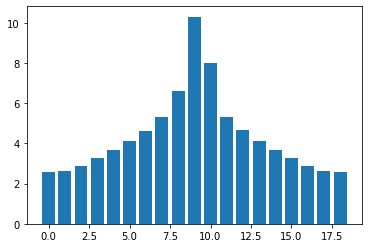

In [304]:
plt.bar(range(19), np.sqrt(((updated_thetas[:-1] - updated_thetas[1:])**2).sum(axis=1)))

<BarContainer object of 28 artists>

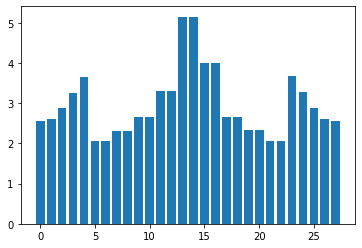

In [302]:
plt.bar(range(28), np.sqrt(((tet[:-1] - tet[1:])**2).sum(axis=1)))

# Evaluate paht WITH finetuned centers

In [94]:
encoding = {8:3, 9:9, 10:3}

centers = np.load('CenterCNN3-32/Stats.npy', allow_pickle=True).item()['final_path']

bn, hidden_layer, n_layers = False, 32, 3

final_path = np.load(f'(2)_SECOND_CNN_ClassificationPath_{bn}_{hidden_layer}_{n_layers}/Stats.npy',
                     allow_pickle=True).item()['final_path']

ctr = 0

new_path = [[] for _ in range(10)]
for path_idx, P in enumerate(final_path):
    L = len(encoding)
    
    group = [c[1: -1] for c in centers[path_idx * L: (path_idx + 1) * L]]
    
    ctr = 0
    for index, line in enumerate(P):
        new_path[path_idx].append(line)

        if index in encoding.keys():            
            new_path[path_idx].append(group[ctr])

            ctr += 1
    
    new_path[path_idx] = np.vstack(new_path[path_idx])

device = 'cuda:1'
dataset='CIFAR10'

for combination in [
                    [False, 32, 3]
                    ]:

    bn, hidden_layer, n_layers = combination    
    name = f'(2)_SECOND_CNN_ClassificationPath_{bn}_{hidden_layer}_{n_layers}'
    
    model_params = {'dataset':dataset, 'n_layers': n_layers, 'hidden_layer':hidden_layer,
                    'batch_norm': bn, 'regularization': 5e-5}
    
    L = ComputeLoss(model=CNN, model_params=model_params, dataset=dataset,
                    part='train', bs=80, device=device)    
        
# loss_between_finetuned = L.evalutae_between_thetas(new_path, alpha=3,
#                                               save_path='CenterCNN3-32/Between_WithCenters.npy')

loss_between_finetuned = np.load('CenterCNN3-32/Between_WithCenters.npy', allow_pickle=True)

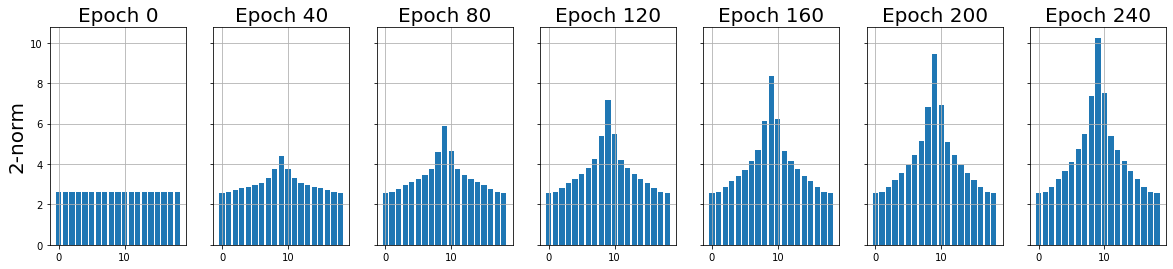

In [134]:
fig, ax = plt.subplots(ncols=7, figsize=(20, 4), sharey=True)

for idx, key in enumerate([0, 40, 80, 120, 160, 200, 240]):
    c = [0] + np.load(name + '/Stats.npy', allow_pickle=True).item()[key]['chain'].tolist()
    c = np.array(c).reshape(10, -1)[:, 1:]
    c = c.mean(axis=0)
    
    ax[idx].bar(range(19), c)
    ax[idx].set_title(f'Epoch {key}', size=20)
    ax[idx].grid()

ax[0].set_ylabel('2-norm', size=20)
plt.show()

<BarContainer object of 19 artists>

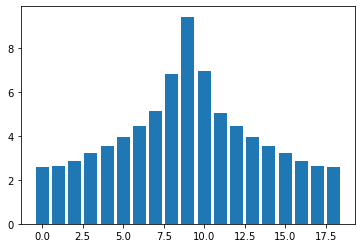

<BarContainer object of 34 artists>

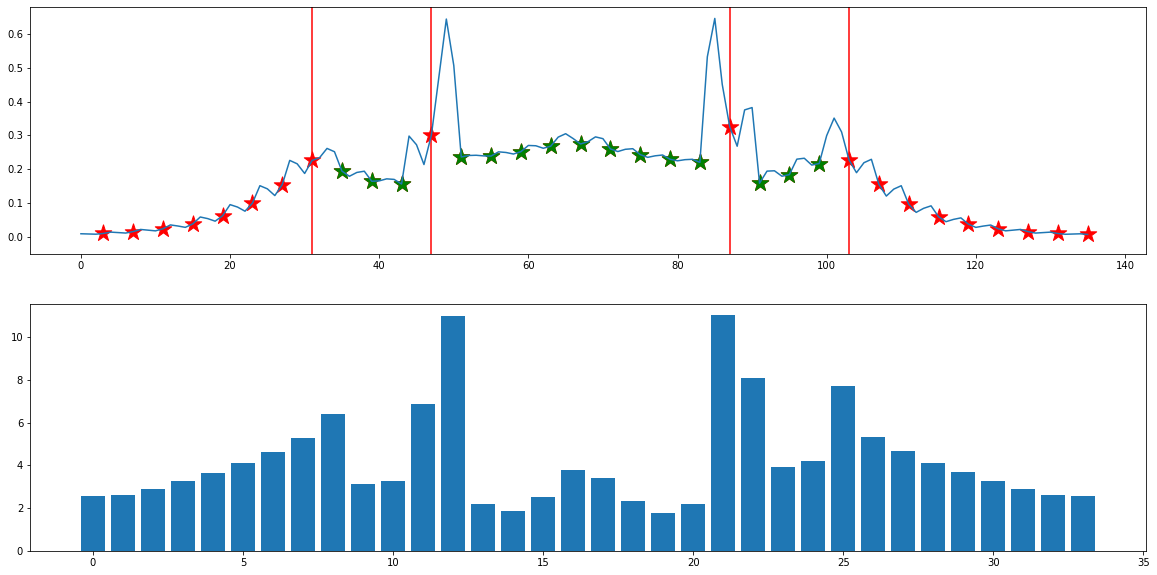

In [86]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 10))

for i in range(stacked.shape[0]):
    if (i+1) % 4 == 0:
        ax[0].scatter(i, stacked[i], marker='*', s=300, c='r')
        
        if i in [31, 47, 87, 103] :
            ax[0].axvline(i, c='r')
        
        if (i in list(range(32, 103))) & (i not in [47, 87]):
            ax[0].scatter(i, stacked[i], marker='*', s=300, c='g')
                
ax[0].plot(stacked)
ax[1].bar(range(34), norm)

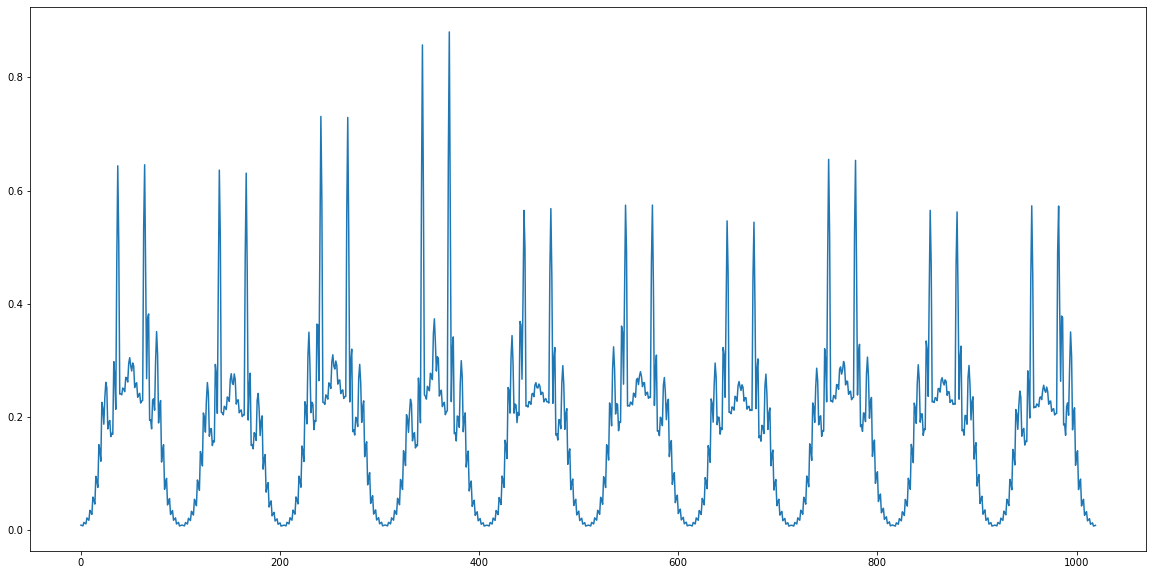

In [21]:
plt.figure(figsize=(20, 10))

plt.plot(loss_between_finetuned.reshape(-1))

# Explicit procedure VS FixConv1

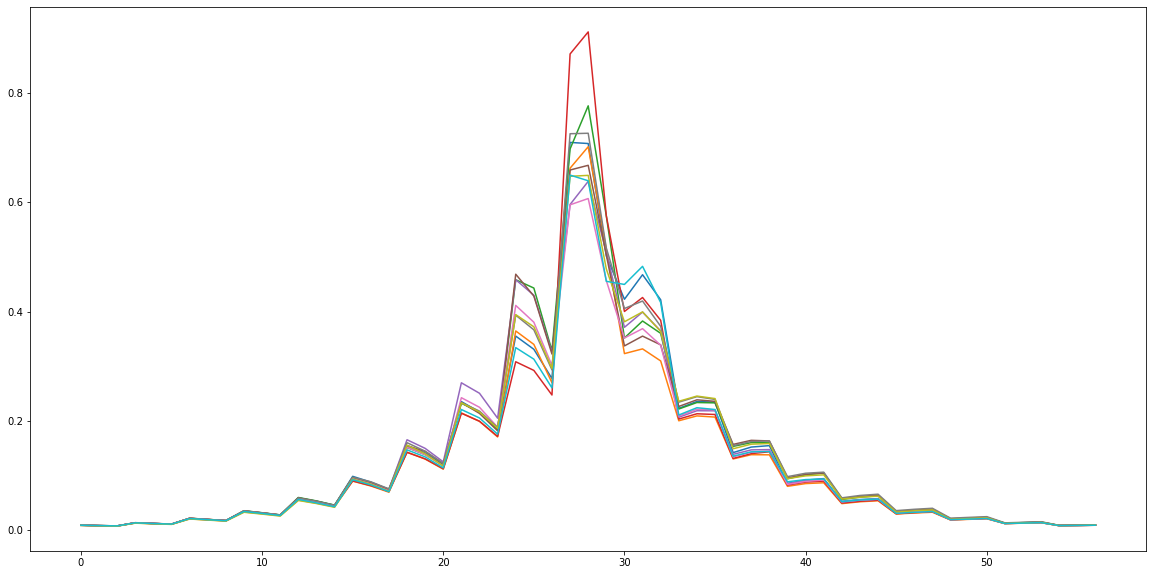

In [10]:
alpha=3
fig,ax = plt.subplots(figsize=(20, 10))

for combination in [[False, 32, 3]]:
    for path, style in zip(['Between_Fix_Head'], ['-']):

        bn, hidden_layer, n_layers = combination    
        name = f'(2)_SECOND_CNN_ClassificationPath_{bn}_{hidden_layer}_{n_layers}'

        loss_between_wide = np.load(f'{name}/{path}.npy', allow_pickle=True)[:, :, 0]
        loss_between_wide = np.split(loss_between_wide.T, 10)
        
        for index, group in enumerate(loss_between_wide):
            
#             ax.plot(range(index * group.shape[0] * alpha, (index+1) * group.shape[0] * alpha),
#                     group.reshape(-1), linestyle=style)
            ax.plot(group.reshape(-1))
            
plt.show()

# Merge Points

In [128]:
center17 = np.load('17_points_CenterCNN3-32/Stats.npy', allow_pickle=True).item()['final_path']
full_path = np.load('(2)_SECOND_CNN_ClassificationPath_False_32_3/Stats.npy', allow_pickle=True).item()['final_path']

In [129]:
def merge_path(center, full_path):
    full_path_with_center = []
    l2 = lambda x, y: np.sqrt(((x-y)**2).sum(axis=1))
    
    for index in range(len(center)):
        anchor_start, anchor_end = center17[index][0], center17[index][-1]
        start_idx, end_idx = l2(full_path[index], anchor_start).argmin(),\
                             l2(full_path[index], anchor_end).argmin()

        full_path_with_center.append(np.vstack([full_path[index][:start_idx], center17[index], full_path[index][end_idx+1:]]))
    
    return full_path_with_center

In [130]:
full_path_with_center = merge_path(center17, full_path)

In [95]:
l2_mean = [np.sqrt(((path[:-1] - path[1:])**2).sum(axis=1)) for path in full_path_with_center]

<BarContainer object of 34 artists>

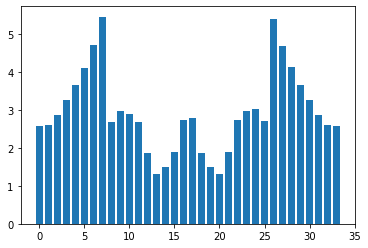

In [100]:
plt.bar(range(34), np.array(l2_mean).mean(axis=0))

In [178]:
device = 'cuda:0'
dataset='CIFAR10'

bn, hidden_layer, n_layers = False, 32, 3
    
model_params = {'dataset':dataset, 'n_layers': n_layers, 'hidden_layer':hidden_layer,
                'batch_norm': bn, 'regularization': 5e-5}

L = ComputeLoss(model=CNN, model_params=model_params, dataset=dataset,
                part='train', bs=50, device=device)

loss = L.complete_evaluation(full_path_with_center, alpha=5, save_path=None, dataset_ratio=1/5)

Ratio 0.16666666666666666
(200, 340, 58826, 1)
Ratio 0.3333333333333333
(200, 340, 58826, 1)
Ratio 0.5
(200, 340, 58826, 1)
Ratio 0.6666666666666666
(200, 340, 58826, 1)
Ratio 0.8333333333333333
(200, 340, 58826, 1)
(200, 350, 58826, 1)


In [179]:
pd.DataFrame(loss).to_csv('FullEvaluation(1).csv', index=False)

<BarContainer object of 34 artists>

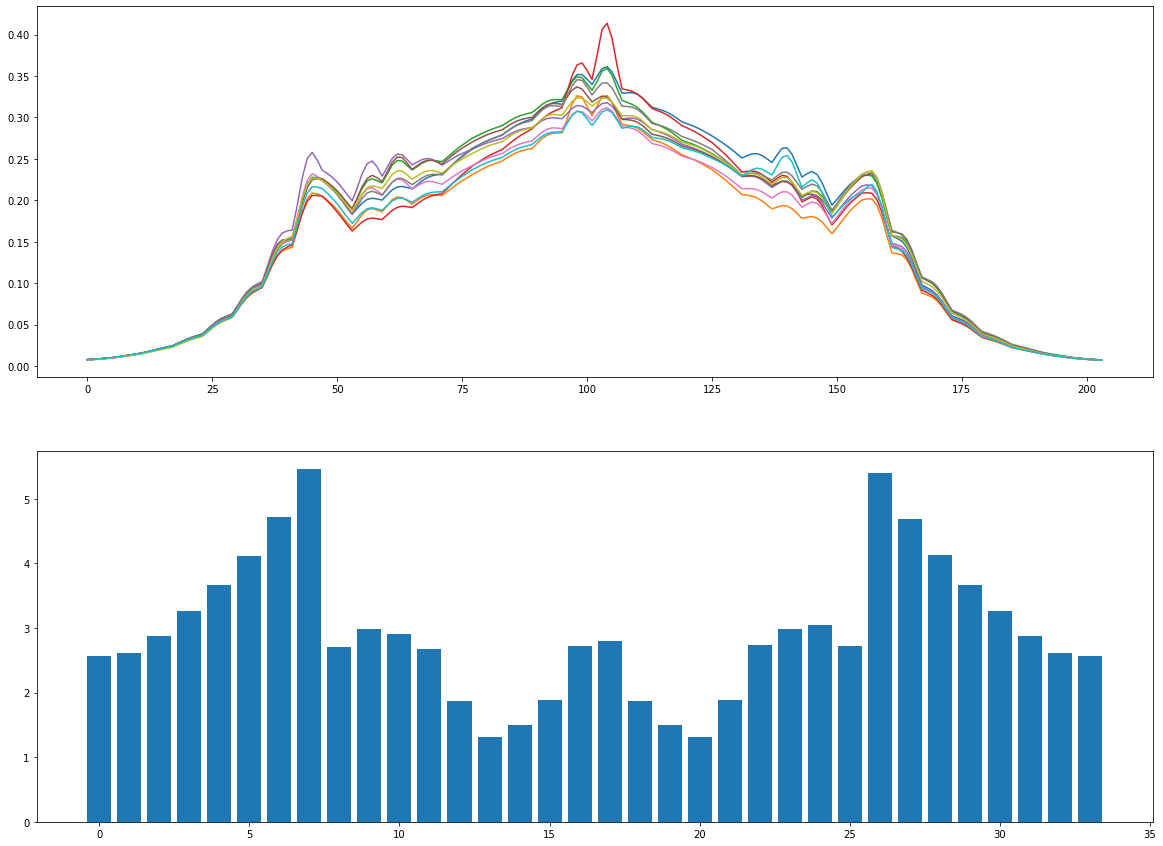

In [184]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 15))


ax[0].plot(loss.T);
ax[1].bar(range(34), np.array(l2_mean).mean(axis=0))

# for i in range(stacked.shape[0]):
#     if (i+1) % 4 == 0:
#         ax[0].scatter(i, stacked[i], marker='*', s=300, c='r')
        
#         if i in [31, 47, 87, 103] :
#             ax[0].axvline(i, c='r')
        
#         if (i in list(range(32, 103))) & (i not in [47, 87]):
#             ax[0].scatter(i, stacked[i], marker='*', s=300, c='g')

In [209]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

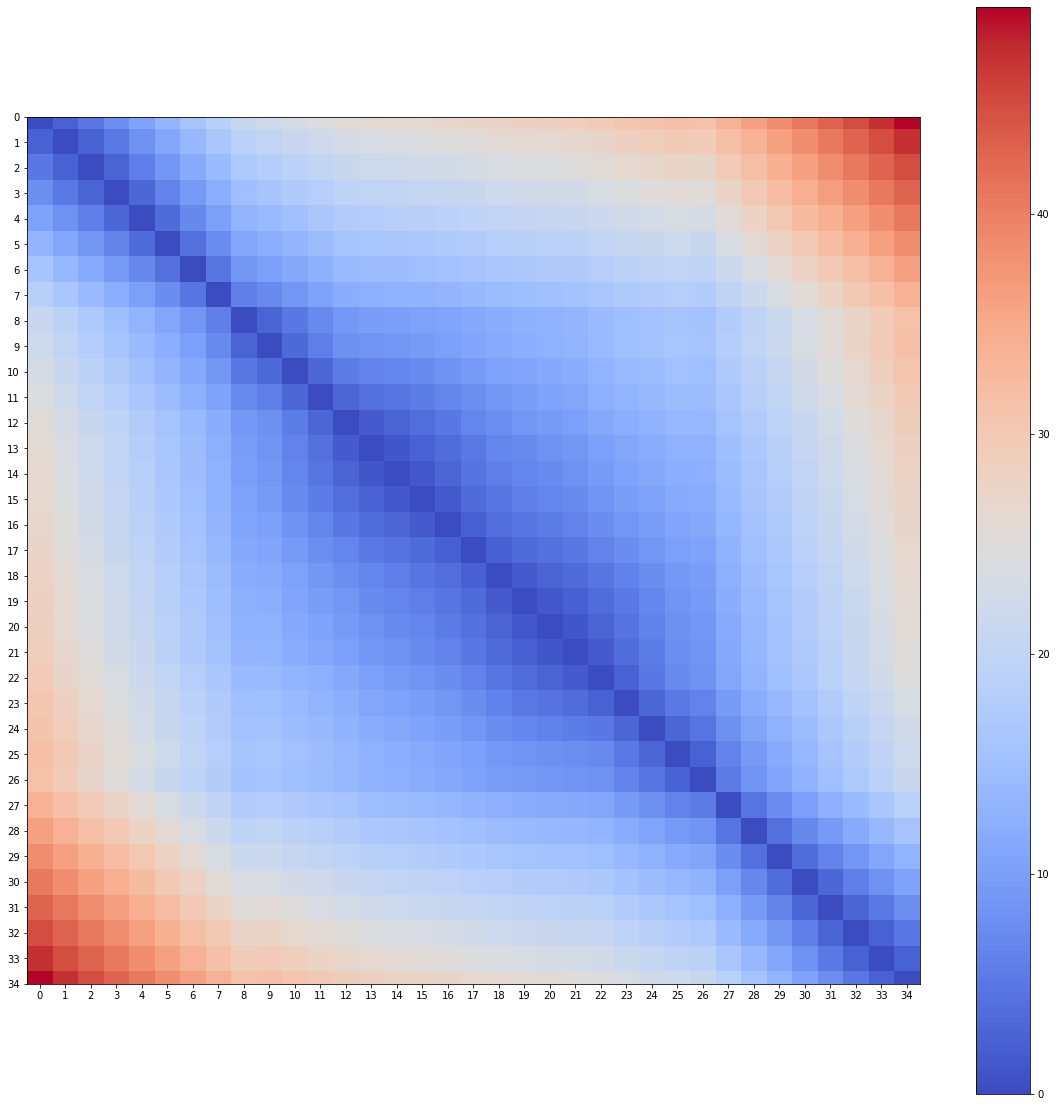

In [207]:
plt.figure(figsize=(20, 20))
plt.imshow(pairwise_distances(full_path_with_center[-6]), cmap='coolwarm', )
plt.colorbar()

plt.yticks(range(35));
plt.xticks(range(35));